In [1]:
import cooler
import numpy as np
import tensorflow as tf
from iced import normalization
import spektral

import matplotlib.pyplot as plt
from IPython import display
import time
tf.keras.backend.set_floatx('float32')

(2432, 2432)
(573, 573)


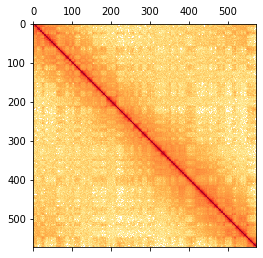

In [2]:
# data from ftp://cooler.csail.mit.edu/coolers/hg19/
name = 'Dixon2012-H1hESC-HindIII-allreps-filtered.100kb.cool'
#name = 'Rao2014-K562-MboI-allreps-filtered.500kb.cool'
c = cooler.Cooler(name)
resolution = c.binsize
mat= c.matrix(balance=True).fetch('chr2')
print(mat.shape)
idxy = ~np.all(np.isnan(mat),axis=0)
M = mat[idxy,:]
Mh = M[:,idxy]

IMG_HEIGHT, IMG_WIDTH = int(Mh.shape[0]/4),int(Mh.shape[1]/4)
img_l = np.zeros(shape=(IMG_HEIGHT, IMG_WIDTH))
for i in list(range(0, len(Mh))):
    x = int(np.floor(i/(len(Mh)/IMG_HEIGHT)))
    for j in list(range(0,len(Mh))):
        y = int(np.floor(j/(len(Mh)/IMG_WIDTH)))
        img_l[x, y] = img_l[x, y] + Mh[i,j]

Ml = img_l
plt.matshow(np.log2(Ml), cmap='YlOrRd')
print(Ml.shape)

In [3]:
import copy
Ml = img_l
#print('original Ml: ', Ml)
#Ml = normalization.ICE_normalization(Ml)
Ml = normalization.SCN_normalization(Ml)
Mh = normalization.SCN_normalization(Mh)

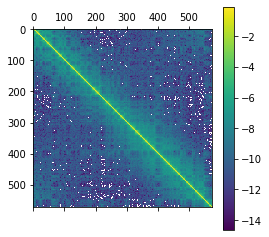

In [4]:
plt.matshow(np.log2(Ml))
plt.colorbar()

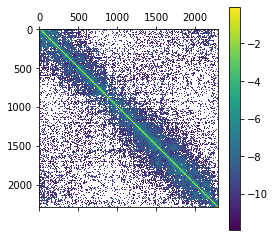

In [5]:
plt.matshow(np.log2(Mh))
plt.colorbar()

128 128
(446, 128, 128)


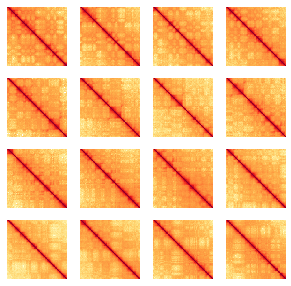

In [6]:
hic_lr = []
IMG_HEIGHT, IMG_WIDTH = int(512/4),int(512/4)
print(IMG_HEIGHT, IMG_WIDTH)
for i in range(len(Ml)-IMG_HEIGHT+1):
    hic_lr.append(Ml[i:i+IMG_HEIGHT, i:i+IMG_WIDTH])
hic_lr = np.array(hic_lr)
print(hic_lr.shape)
fig = plt.figure(figsize=(5, 5))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(np.log2(hic_lr[i*25,:,:]), cmap='YlOrRd')
    plt.axis('off')

512 512
(446, 512, 512)


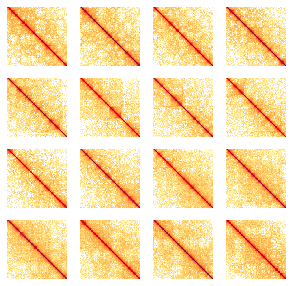

In [7]:
hic_hr = []
IMG_HEIGHT, IMG_WIDTH = int(512),int(512)
print(IMG_HEIGHT, IMG_WIDTH)
for i in range(0,len(Mh)-IMG_HEIGHT+1,4):
    hic_hr.append(Mh[i:i+IMG_HEIGHT, i:i+IMG_WIDTH])
hic_hr = np.array(hic_hr)
print(hic_hr.shape)
fig = plt.figure(figsize=(5, 5))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(np.log2(hic_hr[i*25,:,:]), cmap='YlOrRd')
    plt.axis('off')

In [8]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())
  result.add(tf.keras.layers.MaxPool2D())

  return result

def make_discriminator_model():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[512, 512, 1], name='input_image')
  tar = tf.keras.layers.Input(shape=[512, 512, 1], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])

  down1 = downsample(64, 4, False)(x) 
  down2 = downsample(128, 4)(down1)
  #down3 = downsample(256, 4)(down2)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down2)
  conv = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)

  '''batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)'''

  return tf.keras.Model(inputs=[inp, tar], outputs=conv)

In [9]:
class Rank1Reconstruct(tf.keras.layers.Layer):
    def __init__(self, filters, name='RR'):
        super(Rank1Reconstruct, self).__init__(name=name)
        self.num_outputs = filters
        w_init = tf.ones_initializer()
        self.w = tf.Variable(initial_value=w_init(shape=(1,1,1,filters), dtype='float32'))
        
    def build(self, input_shape):
        pass
        
    def call(self, input):
        v = tf.math.add(input, tf.constant(1e-6, dtype=tf.float32))
        vt = tf.transpose(v, perm=[0,2,1,3])
        rank1m = tf.multiply(tf.multiply(v, vt), self.w)
        return rank1m

class Weight_R1M(tf.keras.layers.Layer):
    def __init__(self, name='WR1M'):
        super(Weight_R1M, self).__init__(name=name)

    def build(self, input_shape):
        w_init = tf.keras.initializers.RandomUniform(minval=0, maxval=4.0)
        self.w = tf.Variable(initial_value=w_init(shape=(1,1,1,input_shape[-1]), dtype='float32'))
    
    def call(self, input):
        self.w.assign(tf.nn.relu(self.w))
        return tf.multiply(input, self.w)

class Sum_R1M(tf.keras.layers.Layer):
    def __init__(self, name='SR1M'):
        super(Sum_R1M, self).__init__(name=name)

    def build(self, input_shape):
        pass
    
    def call(self, input):
        return tf.reduce_sum(input, axis=-1, keepdims=True)

class Normal(tf.keras.layers.Layer):
    def __init__(self, input_dim, name='DW'):
        super(Normal, self).__init__(name=name)
        w_init = tf.ones_initializer()
        self.w = tf.Variable(initial_value=w_init(shape=(1, input_dim, 1, 1), dtype='float32'), trainable=True)
        d_init = tf.zeros_initializer()
        self.d = tf.Variable(initial_value=d_init(shape=(1, input_dim), dtype='float32'), trainable=True)

    def call(self, inputs):
        rowsr = tf.math.sqrt(tf.math.reduce_sum(tf.multiply(inputs, inputs), axis=1, keepdims=True))
        colsr = tf.math.sqrt(tf.math.reduce_sum(tf.multiply(inputs, inputs), axis=2, keepdims=True))
        sumele = tf.math.multiply(rowsr, colsr)
        #tf.math.divide_no_nan(inputs, sumele)
        Div = tf.math.divide_no_nan(inputs, sumele)
        self.w.assign(tf.nn.relu(self.w))
        self.d.assign(tf.nn.relu(self.d))
        WT = tf.transpose(self.w, perm=[0,2,1,3])
        M = tf.multiply(self.w, WT)
        opd = tf.linalg.LinearOperatorToeplitz(self.d, self.d)
        opd = tf.expand_dims(opd.to_dense(), axis=-1)
        return tf.add(tf.multiply(Div, M), opd)

In [10]:
def make_generator_model():
    In = tf.keras.layers.Input(shape=(128, 128, 1), name='In', dtype=tf.float32)
    Decl = tf.keras.layers.Conv2D(64, [1, 128], strides=1, padding='valid', data_format="channels_last", activation='relu', use_bias=False, kernel_constraint=tf.keras.constraints.NonNeg(),kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.01, stddev=0.1),  name='Decl')(In) 
    
    WeiR1Ml = Weight_R1M(name='WR1Ml')(Decl)
    Recl = Rank1Reconstruct(64, name='Recl')(WeiR1Ml)
    Suml = Sum_R1M(name='Suml')(Recl) 
    low_out = Normal(128, name='Out_low')(Suml)

    up_o = tf.keras.layers.UpSampling2D(size=(4,4), data_format='channels_last', name='Upo')(In)

    up_1 = tf.keras.layers.UpSampling2D(size=(4,1), data_format='channels_last', name='UpSample')(WeiR1Ml)
    trans_1 = tf.keras.layers.Conv2D(filters=256, kernel_size=(7,1), strides=(1,1), padding='same', data_format="channels_last", activation='relu', use_bias=False, name='C2DT1')(up_1)
    #trans_2 = tf.keras.layers.Conv2DTranspose(filters=16, kernel_size=(5,1), strides=(2,1), padding='same', data_format="channels_last", activation='relu', use_bias=False, kernel_constraint=tf.keras.constraints.NonNeg(), name='C2DT2')(trans_1)
    Rech = Rank1Reconstruct(256, name='Rech')(trans_1)
    #WeiR1Mh = Weight_R1M(name='WR1Mh')(Rech)
    Sumh = Sum_R1M(name='Sumh')(Rech) 
    high_out = Normal(512, name='Out_high')(Sumh)

    model = tf.keras.models.Model(inputs=[In],outputs=[low_out, high_out, up_o])
    return model

'''p1,p2,heads, gen = make_generator_model()
p1.summary()
p2.summary()
heads[1].summary()
gen.summary()
print(gen.get_layer('Dec1').trainable_variables)'''

"p1,p2,heads, gen = make_generator_model()\np1.summary()\np2.summary()\nheads[1].summary()\ngen.summary()\nprint(gen.get_layer('Dec1').trainable_variables)"

W0412 13:58:32.004419 4650479040 deprecation.py:506] From /Users/huyangyang/anaconda3/envs/TF_base/lib/python3.7/site-packages/tensorflow_core/python/ops/linalg/linear_operator_toeplitz.py:158: calling LinearOperator.__init__ (from tensorflow.python.ops.linalg.linear_operator) with graph_parents is deprecated and will be removed in a future version.
Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
In (InputLayer)                 [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
Decl (Conv2D)                   (None, 128, 1, 64)   8192        In[0][0]                         
___________________________________________________

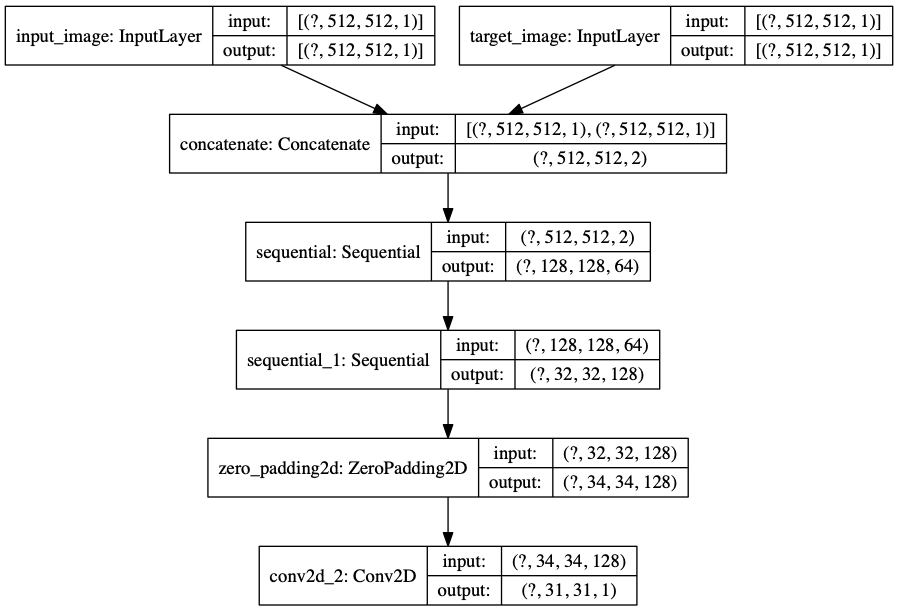

In [11]:
#Gen_low = make_generator_low_model()
#Gen_high = make_generator_high_model()
Gen = make_generator_model()
Dis = make_discriminator_model()
print(Gen.summary())
tf.keras.utils.plot_model(Gen, to_file='G.png',show_shapes=True)
'''print(p1.summary())
tf.keras.utils.plot_model(Gen_high, to_file='G_low.png',show_shapes=True)
print(p2.summary())
tf.keras.utils.plot_model(Gen_high, to_file='G_high.png',show_shapes=True)'''
print(Dis.summary())
tf.keras.utils.plot_model(Dis, to_file='D.png', show_shapes=True)

In [12]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = loss_object(tf.ones_like(real_output), real_output)
    generated_loss = loss_object(tf.zeros_like(fake_output), fake_output)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss
    
def generator_lowr_loss(y_pred, y_true):
    #return cross_entropy(tf.ones_like(fake_output), fake_output)
    return 1 - tf.image.ssim(y_pred, y_true, max_val=1.0)

def generator_highr_loss(d_pred):
    gan_loss = loss_object(tf.ones_like(d_pred), d_pred)
    return gan_loss


In [13]:
generator_optimizer_low = tf.keras.optimizers.Adam()
generator_optimizer_high = tf.keras.optimizers.Adam()
discriminator_optimizer = tf.keras.optimizers.Adagrad()
'''checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=Gen,
                                 discriminator=Dis)'''

'checkpoint_dir = \'./training_checkpoints\'\ncheckpoint_prefix = os.path.join(checkpoint_dir, "ckpt")\ncheckpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,\n                                 discriminator_optimizer=discriminator_optimizer,\n                                 generator=Gen,\n                                 discriminator=Dis)'

In [14]:
@tf.function
def train_step(imgl, imgr):
    with tf.GradientTape() as gen_tape_low, tf.GradientTape() as gen_tape_high, tf.GradientTape() as disc_tape:
        fake_hic = Gen(imgl, training=True)
        fake_hic_l = fake_hic[0]
        fake_hic_h = fake_hic[1]
        img_l_h = fake_hic[2]
        gen_loss_low = generator_lowr_loss(fake_hic_l, imgl)
        #gen_low_v = Gen.trainable_variables
        gen_low_v = []
        gen_low_v += Gen.get_layer('Decl').trainable_variables
        gen_low_v += Gen.get_layer('WR1Ml').trainable_variables
        gen_low_v += Gen.get_layer('Recl').trainable_variables        
        gen_low_v += Gen.get_layer('Out_low').trainable_variables
        gradients_of_generator_low = gen_tape_low.gradient(gen_loss_low, gen_low_v)
        generator_optimizer_low.apply_gradients(zip(gradients_of_generator_low, gen_low_v))

        #disc_generated_output = Dis([fake_hic_h, imgr], training=True)

        gen_loss_high = generator_lowr_loss(fake_hic_h, imgr) #+ generator_highr_loss(disc_generated_output)
        gen_high_v = []
        gen_high_v += Gen.get_layer('C2DT1').trainable_variables
        gen_high_v += Gen.get_layer('Rech').trainable_variables
        #gen_high_v += Gen.get_layer('WR1Mh').trainable_variables
        gen_high_v += Gen.get_layer('Out_high').trainable_variables
        #gen_high_v += Gen.get_layer('C2DT2').trainable_variables
        #gen_high_v += Gen.get_layer('Rech').trainable_variables
        gradients_of_generator_high = gen_tape_high.gradient(gen_loss_high, gen_high_v)
        generator_optimizer_high.apply_gradients(zip(gradients_of_generator_high, gen_high_v))

        '''disc_real_output = Dis([img_l_h, imgr], training=True)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
        discriminator_gradients = disc_tape.gradient(disc_loss, Dis.trainable_variables)
        discriminator_optimizer.apply_gradients(zip(discriminator_gradients, Dis.trainable_variables))'''

In [15]:
def train(dataset, epochs, BATCH_SIZE):
    #print(dataset)
    for epoch in range(epochs):
        start = time.time()
        for i, (low_m, high_m) in enumerate(dataset.take(1)):
            train_step(tf.dtypes.cast(low_m, tf.float32), tf.dtypes.cast(high_m, tf.float32))

        # Save the model every 15 epochs
        if (epoch + 1) % 25 == 0:
            # Produce images for the GIF as we go
            display.clear_output(wait=True)
            generate_and_save_images(Gen, epoch + 1, None)
            #checkpoint.save(file_prefix = checkpoint_prefix)
        print ('Time for epoch {} is {} sec.'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    #display.clear_output(wait=True)
    #generate_and_save_images(Gen, epochs, None)

In [18]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    test_input = np.ones(shape=[1,128,128,1])
    test_input[0,:,:,0] = hic_lr[0,:,:]
    pre = model(test_input, training=False)
    predictions = np.squeeze(pre[0])
    #print('Pred: ', predictions)
    rows = 3
    cols = 4
    plt.figure(figsize=(6, 6), constrained_layout=True)
    plt.subplot(rows,cols,1)
    plt.imshow(np.log2(np.squeeze(hic_lr[0,:,:])))
    #plt.axis('off')
    plt.title('Original')
    plt.subplot(rows,cols,2)
    plt.imshow(np.log2(predictions))
    #plt.axis('off')
    plt.title('X Hat')
    plt.subplot(rows,cols,3)
    plt.imshow(np.log2(np.squeeze(hic_lr[0,:,:])-predictions), cmap='RdBu_r')
    #plt.axis('off')
    plt.title('Diff')

    intermediate_layer_model = tf.keras.models.Model(inputs=model.input, outputs=model.get_layer('Suml').output )
    intermediate_output = intermediate_layer_model.predict(test_input)
    plt.subplot(rows,cols,4)
    plt.imshow(np.log2(np.squeeze(intermediate_output)), cmap='RdBu_r')
    #plt.axis('off')
    plt.title('before WX+b')
    m = model.get_layer('Out_high').get_weights()
    plt.subplot(rows,cols,5)
    plt.plot(np.squeeze(m[0]))
    plt.title('W')
    plt.subplot(rows,cols,6)
    plt.plot(np.squeeze(m[1]))
    plt.title('bias')

    intermediate_layer_model = tf.keras.models.Model(inputs=model.input, outputs=model.get_layer('Sumh').output )
    intermediate_output = np.squeeze(pre[1])
    plt.subplot(rows,cols,7)
    plt.imshow(np.log2(np.squeeze(intermediate_output)), cmap='RdBu_r')
    #plt.axis('off')
    plt.title('HX Hat')

    intermediate_layer_model = tf.keras.models.Model(inputs=model.input, outputs=model.get_layer('Decl').output )
    intermediate_output = intermediate_layer_model.predict(test_input)
    plt.subplot(rows,cols,8)
    plt.imshow(np.squeeze(intermediate_output))
    plt.axis('off')
    plt.title('Decl')
    intermediate_layer_model = tf.keras.models.Model(inputs=model.input, outputs=model.get_layer('WR1Ml').output )
    intermediate_output = intermediate_layer_model.predict(test_input)
    plt.subplot(rows,cols,9)
    plt.imshow(np.squeeze(intermediate_output))
    plt.axis('off')
    plt.title('WR1Ml')

    intermediate_layer_model = tf.keras.models.Model(inputs=model.input, outputs=model.get_layer('UpSample').output )
    intermediate_output = intermediate_layer_model.predict(test_input)
    plt.subplot(rows,cols,10)
    plt.imshow(np.squeeze(intermediate_output))
    plt.axis('off')
    plt.title('UpSample')

    intermediate_layer_model = tf.keras.models.Model(inputs=model.input, outputs=model.get_layer('C2DT1').output )
    intermediate_output = intermediate_layer_model.predict(test_input)
    plt.subplot(rows,cols,11)
    plt.imshow(np.squeeze(intermediate_output))
    plt.axis('off')
    plt.title('C2DT1')

    plt.savefig('./lvl2/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [19]:
EPOCHS = 800
BUFFER_SIZE = 1
BATCH_SIZE = 3
train_data = tf.data.Dataset.from_tensor_slices((hic_lr[..., np.newaxis], hic_hr[..., np.newaxis])).batch(BATCH_SIZE)
#train_low = tf.data.Dataset.from_tensor_slices(hic_lr[..., np.newaxis]).batch(BATCH_SIZE)
#train_high = tf.data.Dataset.from_tensor_slices(hic_hr[..., np.newaxis]).batch(BATCH_SIZE)

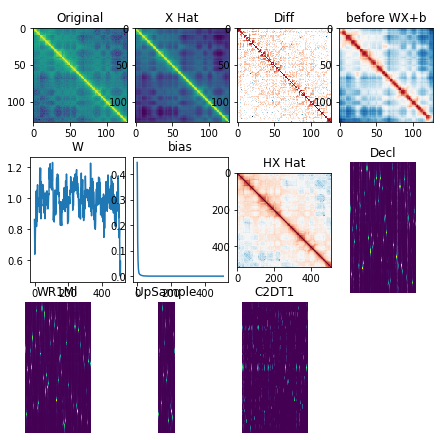

Time for epoch 800 is 21.227099180221558 sec.


In [20]:
train(train_data, EPOCHS, BATCH_SIZE)

T:  2618.561130367139
pred:  2677.4717
diff:  660.5937612236224


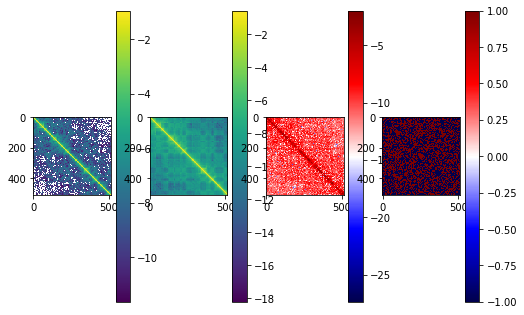

In [23]:
import iced
import copy
idx = 0
test_input = np.ones(shape=[1,128,128,1])
test_input[0,:,:,0] = copy.copy(hic_lr[idx,:,:])
predictions = Gen(test_input, training=False)
hic_pred = np.squeeze((predictions[1]).numpy())
#hic_pred = normalization.SCN_normalization(hic_pred)
plt.figure(figsize=(8,24))
plt.subplot(1,4,1)
T = np.squeeze(hic_hr[idx,:,:])
pct = np.percentile(T, 99.9)
T[T>pct] = pct
plt.imshow(np.log2(T))
plt.colorbar()
plt.subplot(1,4,2)
plt.imshow(np.log2(hic_pred))
plt.colorbar()
plt.subplot(1,4,3)
diff = (T - hic_pred)
plt.imshow(np.log2(np.abs(diff)), cmap='seismic')
plt.colorbar()
plt.subplot(1,4,4)
diff[diff>0] = 1
diff[diff<0] = -1
plt.imshow((diff), cmap='seismic')
plt.colorbar()

print('T: ', np.sum(T))
print('pred: ', np.sum(hic_pred))
print('diff: ', np.sum(np.abs(T-hic_pred)))

Text(0.5, 1.0, 'Estimate image')

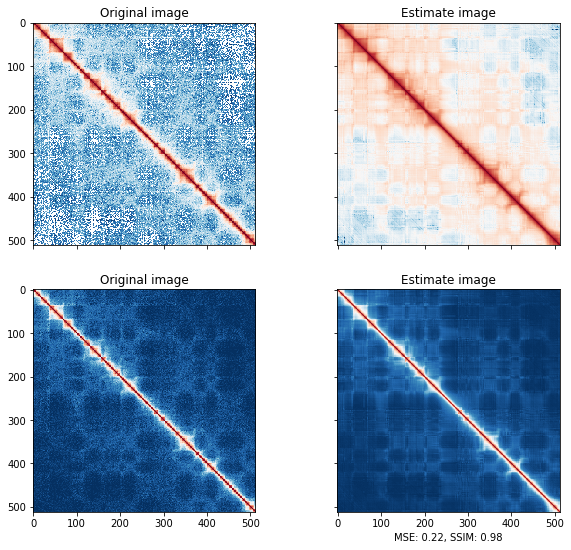

In [28]:
from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import normalized_root_mse
def mse(x, y):
    return np.linalg.norm(x - y) #The Frobenius norm

T = np.squeeze(hic_hr[idx,:,:])
pct = np.percentile(T, 100)
T[T>pct] = pct

P = copy.copy(hic_pred)
#P = np.squeeze(hic_hr[0,:,:])
pct = np.percentile(P, 100)
P[P>pct] = pct

mse_noise = normalized_root_mse(T, P)
ssim_noise = ssim(T, P, data_range=T.max() - T.min())

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 9),
                         sharex=True, sharey=True)
ax = axes.ravel()

label = 'MSE: {:.2f}, SSIM: {:.2f}'

axes[0,0].imshow(np.log2(100*T), cmap='RdBu_r')
#axes[0,0].set_xlabel(label.format(mse_noise, ssim_noise))
axes[0,0].set_title('Original image')

axes[0,1].imshow(np.log2(100*P), cmap='RdBu_r')
#axes[0,1].set_xlabel(label.format(mse_noise, ssim_noise))
axes[0,1].set_title('Estimate image')

axes[1,0].imshow(np.log1p(100*T), cmap='RdBu_r')
#axes[1,0].set_xlabel(label.format(mse_noise, ssim_noise))
axes[1,0].set_title('Original image')

axes[1,1].imshow(np.log1p(100*P), cmap='RdBu_r')
axes[1,1].set_xlabel(label.format(mse_noise, ssim_noise))
axes[1,1].set_title('Estimate image')

In [26]:
Gen.save('./saved_model/gen_model') 

W0412 15:28:08.706377 4650479040 deprecation.py:506] From /Users/huyangyang/anaconda3/envs/TF_base/lib/python3.7/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1786: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [ ]:
intermediate_layer_model = tf.keras.models.Model(inputs=Gen.input, outputs=Gen.get_layer('Rec1').output )
intermediate_output = intermediate_layer_model.predict(test_input)
#print(intermediate_output.shape)
step = 2
fig = plt.figure(figsize=(10, 10), constrained_layout=False)
for i in range(0,256):#,intermediate_output.shape[3],step):
    #print(i)
    plt.subplot(16, 16, i+1)
    plt.imshow((np.squeeze(intermediate_output[0, :, :, i])), cmap='YlOrRd')
    plt.axis('off')
#plt.savefig('./lvl4/image_features_log2.png')
plt.show()

In [27]:
import imageio
import glob
anim_file = 'gcn_1.gif'
with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('./lvl2/image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)